In [2]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2026-01-11 20:11:53--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  2.28MB/s    in 1.4s    

2026-01-11 20:11:56 (2.28 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [1]:
!nvidia-smi

Sun Jan 11 20:11:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
df_ = pd.read_csv('AirlineTweets.csv')

In [5]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df = df_[['airline_sentiment', 'text']].copy()

In [7]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

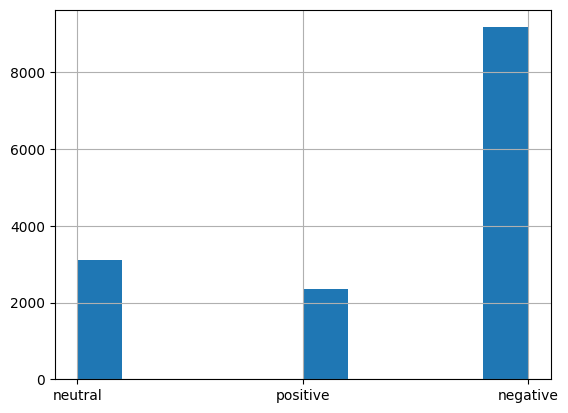

In [8]:
df['airline_sentiment'].hist()

In [9]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [10]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=None)

In [11]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [12]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [14]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [15]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [15]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

In [16]:
# if you already have a train-test split:
# load_dataset(
#     'csv',
#     data_files={'train': ['train1.csv', 'train2.csv'],
#                 'test': 'test.csv'
#     }
# )

In [16]:
checkpoint = 'distilbert-base-cased'

In [17]:
from transformers import AutoTokenizer

In [18]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [19]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [20]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

In [22]:
from transformers import AutoModelForSequenceClassification, \
  Trainer, TrainingArguments

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=3)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
!pip install torchinfo

In [25]:
from torchinfo import summary

In [26]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [27]:
training_args = TrainingArguments(
  output_dir='training_dir',
  save_strategy='epoch',
  num_train_epochs=3,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [28]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [29]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-709814514.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
500,0.544100
1000,0.346800
1500,0.247800


TrainOutput(global_step=1923, training_loss=0.33083810077256603, metrics={'train_runtime': 210.309, 'train_samples_per_second': 146.185, 'train_steps_per_second': 9.144, 'total_flos': 388537948763424.0, 'train_loss': 0.33083810077256603, 'epoch': 3.0})

In [31]:
trainer.evaluate()

{'eval_loss': 0.6281172037124634,
 'eval_accuracy': 0.8349271402550091,
 'eval_f1': 0.7812588109358001,
 'eval_runtime': 7.8224,
 'eval_samples_per_second': 561.462,
 'eval_steps_per_second': 8.821,
 'epoch': 3.0}

In [33]:
!ls

AirlineTweets.csv  data.csv  sample_data  training_dir	wandb


In [32]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [34]:
from transformers import pipeline

In [35]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1282',
                      device=0)

Device set to use cuda:0


In [40]:
split['test']['sentence']

Column(['@JetBlue thank you!', '@united thanks', "@SouthwestAir Thank you. The email about RR pts &amp; how to gain more wasn't clear so all of mine r gone. Anything u can do is appreciated.", "@AmericanAir Yes, thanks I found those, didn't see the gray tab at first :)", "@SouthwestAir my bday was yesterday and my girl gave birth to my first born and I couldn't get a courtesy flight change from Lynn... THANKS!"])

In [41]:
test_pred = savedmodel(list(split['test']['sentence']))

In [42]:
test_pred

[{'label': 'LABEL_1', 'score': 0.9217823147773743},
 {'label': 'LABEL_1', 'score': 0.9342994093894958},
 {'label': 'LABEL_1', 'score': 0.46237099170684814},
 {'label': 'LABEL_1', 'score': 0.8603202700614929},
 {'label': 'LABEL_2', 'score': 0.6628552079200745},
 {'label': 'LABEL_0', 'score': 0.9957069754600525},
 {'label': 'LABEL_2', 'score': 0.9496583938598633},
 {'label': 'LABEL_0', 'score': 0.712543785572052},
 {'label': 'LABEL_1', 'score': 0.7245153188705444},
 {'label': 'LABEL_0', 'score': 0.9965367317199707},
 {'label': 'LABEL_0', 'score': 0.9141576886177063},
 {'label': 'LABEL_0', 'score': 0.9945080876350403},
 {'label': 'LABEL_1', 'score': 0.9507004618644714},
 {'label': 'LABEL_0', 'score': 0.9947519898414612},
 {'label': 'LABEL_2', 'score': 0.9257534146308899},
 {'label': 'LABEL_1', 'score': 0.5237501263618469},
 {'label': 'LABEL_1', 'score': 0.40411460399627686},
 {'label': 'LABEL_0', 'score': 0.9966121315956116},
 {'label': 'LABEL_0', 'score': 0.9451183676719666},
 {'label': 

In [43]:
def get_label(d):
  return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [44]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.8356102003642987


In [45]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.776317632296446


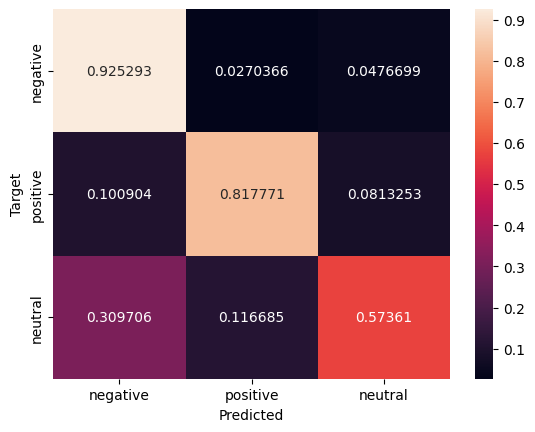

In [46]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive', 'neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)